# Data Fusion Assignment 3: Particle Filter


The goal of the particle filter assignment is to estimate the position of
a moving robot. The robot moves around in a 2D world that contains various
landmarks. The robot position is represented by the red star. The black dots represent the landmarks and the green dots represent the particles. The distance to each of the landmarks is measured by the robot.

The robot state contains the position and orientation of the robot 
(x, y, theta). Template code is provided in which all information needed
is provided. Three cells need to be completed (noticeable by the
!!! FILL IN !!! comments):
- The particle_move cell (4p)
- The get_likelihood cell (4p)
- The resampling function in the main skeleton (2p)

The !!! DO NOT MODIFY !!! indicators mean that if you are going to submit
your assignment, make sure that it is not modified as to default, this
might mess up the autograding. Of course you are welcome to change some
parameters and see how it affects the results for your own interpretation.

Before we start implementing the Particle Filter, we import for you the necessary libraries and allow
plotting of figures (disabled when using autograder).

In [1]:
# Imports !!! DO NOT MODIFY !!!

plotting = False
calc_smt = False
if __name__ == '__main__':
    plotting = True
    calc_smt = True
    import matplotlib.pyplot as plt

import numpy as np
import scipy.io
from IPython import display
import time

In the next cell we define some of the parameters used for this assignment. The default settings are used for the autograding, but feel free to select a different set of landmarks to see the results. 

In [2]:
########## SETTINGS  !!! DO NOT MODIFY !!!

# Number of simulated time steps
n_steps = 20

# Landmarks measured by the robot, you may try various configurations
landmarks  = np.array([[20, 20], [80, 80], [20, 80], [80, 20]])
# landmarks  = np.array([[20, 20], [80, 80]])
#landmarks = np.array([50, 50])

# Size of the world
world_width = 100
world_height = 100
world = np.array([world_width, world_height])

# Number of particles
N = 1000

# Plotting options
MSlm = 15  # Size marker landmarks
MSpar = 5 # Size marker particle
                      
### Models

# Process model: process noise in each direction
sigma_forward = 0.25
sigma_turn = 0.1

# Input
u_forward = 5
u_turn = 0.05

# Measurment model: Gaussian measurement noise std
sigma_meas = 3

# set random seed (don't change for autograding)
if not calc_smt:
    np.random.seed(0)

We initialize the robot's true pose (x, y, theta) randomly, the states for all particles are sampled uniformly and initially all particle weights are equal.

In [3]:
########## INITIALIZATION !!! DO NOT MODIFY !!!

pi = np.pi

# Initial robot pose
robot_x = np.random.rand(1) * world_width
robot_y = np.random.rand(1) * world_height
robot_th = np.random.rand(1) * 2 * pi
robot_pose = np.array([robot_x, robot_y, robot_th])

# Initialize N particles and weights
particles = np.ones((3, N))  # for efficiency purposes
w = np.squeeze(np.ones((1,N))/N)
for i in range(0, N):
    particles[0,i] = np.random.rand(1)*world_width
    particles[1,i] = np.random.rand(1)*world_height
    particles[2,i] = np.random.rand(1)*2*pi
    
print(particles.shape)
print(w.shape)

(3, 1000)
(1000,)


There are a couple of helper functions that you don't have to fill in yourselves.

- wrap_to_2pi returns your input within a (0, 2pi) range.
- normrnd samples from a normal distribution given a mean and standard deviation.
- normpdf computes pdf of the input using a normal distribution with mean mu and variance sigma.

In [4]:
########## HELPER FUNCTIONS !!! DO NOT MODIFY !!!


def wrap_to_2pi(x):
    # fit x such that it lies between 0 and 2pi
    
    pi = np.pi
    y = x

    while (y<0 or y>(2*pi)):
    
        if y > (2*pi):
            y = y - (2*pi)
    
        if y < 0:
            y = y + (2*pi)
        
    return y


def normrnd(mu, sigma):
    # normrnd sample from a normal distribution with mean mu and std sigma

    if not np.ndim(mu) == 0:
        print("mean must be scalar")
        mu=mu[0]
        
    if not np.ndim(sigma) == 0:
        print("standard deviation must be scalar")
        sigma=sigma[0]
    
    # used for autograding
    if not calc_smt:
        np.random.seed(0)
#         print("calc_smt is True")

    y = mu+sigma*np.random.randn()

    return y


def normpdf(x, mu, sigma):
    # normpdf compute pdf at x using a normal distribution with mean mu and variance sigma
    
    if not np.ndim(mu) == 0:
        print("mean must be scalar")
        mu=mu[0]
        
    if not np.ndim(sigma) == 0:
        print("standard deviation must be scalar")
        sigma=sigma[0]

    y = np.zeros(len(x))
    
    for i in range(0, len(x)):
        y[i] = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp( - (x[i]-mu)**2 / (2*sigma**2))

    return y

In the next cell we simulate the robot moving. We take the latest position of the robot, and update its orientation (theta) by including the turn and the noise. The x- and y-position are updated by including the x- and y-components of the distance that the robot has to move and the noise. The last step makes sure that the robot stays inside the world (if it would drive out of the world on the right side, it will appear again on the left). Notice the robot pose computed here represents the 'ground truth', the robot pose we are trying to estimate with out particle filter.

In [5]:
########## ROBOT_SIM_MOVE !!! DO NOT MODIFY !!!

def robot_sim_move(full_robot_pose, world, forward, turn):
    
    # All noise signals are zero mean Gaussians
    mu = 0
    sigma_forward = 0.5
    sigma_turn = 0.1

    # Get most recent robot pose
    robot_pose = np.copy(full_robot_pose[:,-1])
    
    # Update the orientation
    robot_pose[2] = wrap_to_2pi(robot_pose[2] + turn + normrnd(mu, sigma_turn))

    # Distance robot has to move
    distance = forward + normrnd(mu, sigma_forward)

    # Update (x,y)-position
    robot_pose[0] = robot_pose[0] + np.cos(robot_pose[2]) * distance
    robot_pose[1] = robot_pose[1] + np.sin(robot_pose[2]) * distance
    

    # Make sure the robot stays inside the (cyclic) world
    for i in range(0, 2):
        robot_pose[i] = robot_pose[i] % world[i]

    robot_pose = np.expand_dims(robot_pose, axis=1)
    full_robot_pose = np.concatenate((full_robot_pose, robot_pose), axis=1)
    
    return full_robot_pose


In the next cell we simulate the measurement of the robot. We take the last position of the robot and calculate the distance to each of the landmarks and add some disturbance (which represents the measurement noise). 

In [6]:
########## ROBOT_SIM_MEASURE !!! DO NOT MODIFY !!!


def robot_sim_measure(full_robot_pose, landmarks, sigma):
    # Zero mean Gaussian measurement noise
    mu = 0
    z = np.zeros((landmarks.shape[0],1))

    # Get most recent robot pose
    robot_pose = np.copy(full_robot_pose[:,-1])

    # For all landmarks
    for i in range(0, landmarks.shape[0]):
        # Calculate distance to landmark
        distance = np.sqrt((robot_pose[0] - landmarks[i,0]) ** 2 + (robot_pose[1] - landmarks[i,1]) ** 2)
        
        # Disturb measurement with measurement noise
        z[i] = distance + normrnd(mu, sigma)
    
    return z


In [7]:
########## SHOW_WORLD !!! DO NOT MODIFY !!!

def show_world(world, landmarks, j):
    
    LW = 5
    MSlm = 15
    
    plt.rcParams['figure.figsize'] = [10,10]

    plt.figure(j)
    
    for i in range(0, landmarks.shape[0]):
        plt.plot(landmarks[i,0], landmarks[i,1], 'ko', markersize = MSlm, linewidth = LW)
    
    plt.xlim(0, world[0])
    plt.ylim(0, world[1])

    return
    

# Assignment

In the next cell, the implementation of the particle filter starts. The third function in the block below implements the prediction step for a single particle. It takes a particle (position and heading) as well as some other information and then moves the particle. The `particle_move` function is given, but you need to fill in the functions to calculate the distance the particle will need to be moved forward and the amount the particle heading is expected to change (`calculate_motion_distance`). In addition, the function `update_particle`, that changes the actual particle needs to be completed. Later, this `particle_move` function is called in a for-loop for each particle separately.

In [8]:
########## PARTILCE_MOVE !!! FILL IN !!!

### Make sure that your parameters match the return parameters (DO NOT CHANGE THESE!)

def calculate_motion_distance(forward, turn, mu, sigma_forward, sigma_turn):
    
    # TODO: draw noise samples for the forward motion and angular motion (zero mean)
    for_noise = normrnd(mu, sigma_forward)
    turn_noise = normrnd(mu, sigma_turn)
    
    distance_forward = forward + for_noise
    distance_turn = turn + turn_noise
    
    # TODO: calculate the distance for the forward motion (0.5p) and the angular motion (0.5p)

    
    return distance_forward, distance_turn


def update_particle(particle, distance_forward, distance_turn):
    
    # TODO: update particle (particle[0]: x, particle[1]: y, particle[2]: theta)
    # particle[0] (1p), particle[1] (1p), particle[2] (1p)
    
    
    particle[2] = wrap_to_2pi(particle[2] + distance_turn)
    
    particle[1] = particle[1] + np.sin(particle[2]) * distance_forward
    particle[0] = particle[0] + np.cos(particle[2]) * distance_forward
    
    
    return particle


##### !!! DO NOT MODIFY !!!
def particle_move(particle, world, forward, turn, sigma_forward, sigma_turn):
    
    # check input
    if particles.shape[0] != 3:
        print("Particle p has size: ", particles.shape[0], ", but should be 3 (x, y, th)")
        
    # Motion model noise
    mu = 0
    
    distance_forward, distance_turn = calculate_motion_distance(forward, turn, mu, sigma_forward, sigma_turn)
    
    particle = update_particle(particle, distance_forward, distance_turn)
    

    # Make sure the particle stays inside the (cyclic) world
    for i in range(0, 2):
        particle[i] = particle[i] % world[i]

    return particle

In the next cell we are going to update the weights of the particles (update step) using the likelihoods. Again, the main function is given, but you have to fill in the remaining functions. Each particle is passed separately again. First, you calculate the distance from the particle to each of the landmarks, and then you use this distance to determine a probability which then is used again to update the likelihood. Note that in the main function, the i of the for-loop of each landmark is passed as well.

In [9]:
########## GET_LIKELIHOOD !!! FILL IN !!!

### Make sure that your parameters match the return parameters (DO NOT CHANGE THESE!)
### You don't need to use all given parameters in each function, this is required for autograding, do not change this


def calculate_distance_pl(particle, landmarks, measurements, sigma, distance_pl, probability, p_likelihood, i):
    
    # TODO:   get distance from particle to landmark (predicted measurement) (2p)
    
    distance_pl = np.sqrt((particle[0] - landmarks[i,0]) ** 2 + (particle[1] - landmarks[i,1]) ** 2)
    
    return distance_pl


def calculate_probability(particle, landmarks, measurements, sigma, distance_pl, probability, p_likelihood, i):
    
    # TODO:   map this predicted measurement to probability using actual
    #         measurement and the measurement standard deviation sigma (1p)
    
    probability = normpdf(measurements[i], distance_pl, sigma)
    
    return probability


def calculate_likelihood(particle, landmarks, measurements, sigma, distance_pl, probability, p_likelihood, i):
    
    # TODO:   the measurement likelihood p is product of n_landmark probabilities (1p)
    
    p_likelihood = p_likelihood * probability
    return p_likelihood


def get_likelihood(particle, landmarks, measurements, sigma):
        
    if landmarks.shape[0] != measurements.shape[0]:
        print("Number of measurements does not correspond to number of landmarks!")
    
    
    distance_pl = 0
    probability = 0
    
    # Initialize probability to be one
    p_likelihood = 1
    
    # TODO: For each measurement (distance to a single landmark)
    for i in range(landmarks.shape[0]):
        distance_pl = calculate_distance_pl(particle, landmarks, measurements, sigma, distance_pl, probability, p_likelihood, i)
        probability = calculate_probability(particle, landmarks, measurements, sigma, distance_pl, probability, p_likelihood, i)
        p_likelihood = calculate_likelihood(particle, landmarks, measurements, sigma, distance_pl, probability, p_likelihood, i)
        #print(p_likelihood)
    return p_likelihood

The next cell contains the main skeleton where all of aboves functions are called. The one remaining function to be filled in is the resampling of the particles and its weights. You are expected to implement multinomial resampling method yourself. 

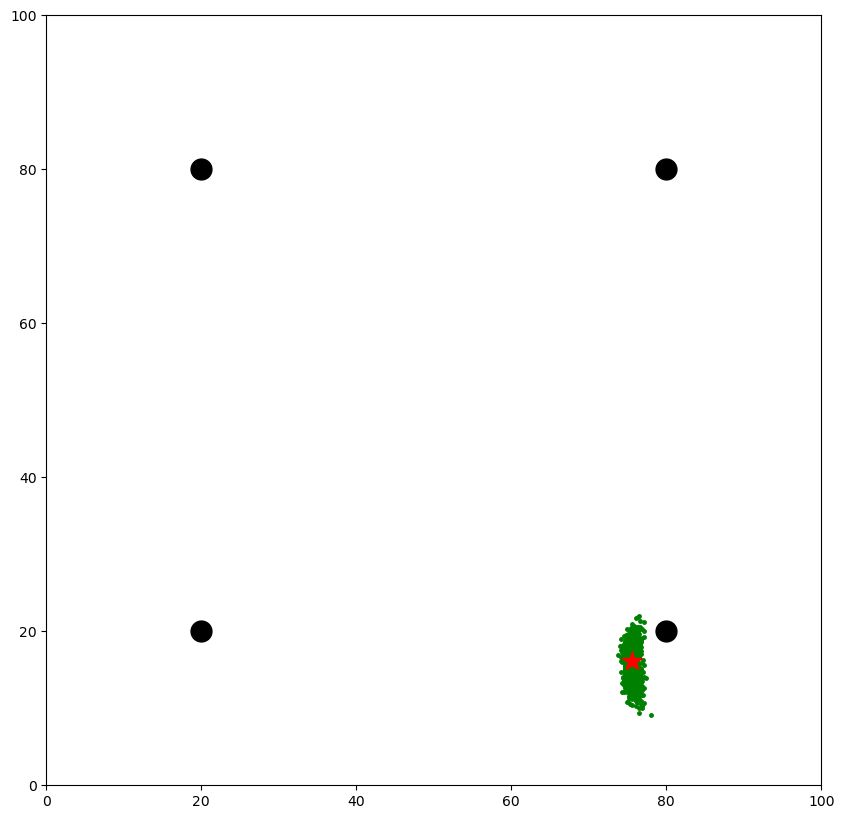

<Figure size 1000x1000 with 0 Axes>

In [10]:
########## MAIN_SKELETON !!! FILL IN !!!

### Make sure that your parameters match the return parameters (DO NOT CHANGE THESE!)


def resampling(particles, w):
    
    # used for autograding, do not change
    if not calc_smt:
        np.random.seed(0)
    

    # TODO: implement resampling using multinomial resampling method (2p)

    w /= np.sum(w)
    
    # Compute the cumulative sum of the weights
    w_s = np.cumsum(w)
    
    # Generate the new set of particles by sampling from the old set with replacement
    new_particles = np.zeros_like(particles)
    
    for i in range(len(w)):
        r = np.random.rand()
        j = np.searchsorted(w_s, r)
        new_particles[:,i] = particles[:,j]
    
    # Reset the weights to be uniform
    w.fill(1 / len(w))
        
    return new_particles, w



##### !!! DO NOT MODIFY !!!

## start simulation
for n in range(0, n_steps):

    ## Move the simulated robot
    robot_pose = robot_sim_move(robot_pose, world, u_forward, u_turn)

    ## Simulate a measurement
    z = robot_sim_measure(robot_pose, landmarks, sigma_meas)

    ## Prediction step: propagate particles using motion model
    for i in range(0, N):
        particles[:,i] = particle_move(particles[:,i], world, u_forward, u_turn, sigma_forward, sigma_turn)

    if plotting:
    # Show propagated particles
        display.clear_output(wait=True) 
        show_world(world, landmarks, 1)
        plt.plot(particles[0,:],particles[1,:],'g.', markersize = MSpar)

    ## Calculate likelihood: particle weights
    for i in range(0, N):
        w[i] = get_likelihood(particles[:,i], landmarks, z, sigma_meas) 

    # update particles
    particles, w = resampling(particles, w)


    if plotting:
        ## Plot robot pose and pause
        plt.plot(robot_pose[0,-1], robot_pose[1,-1], 'r-*', markersize=15, linewidth=2)
        display.display(plt.gcf())
        plt.clf()
        time.sleep(0.25)
